<a href="https://colab.research.google.com/github/Simurgh818/temporal_criticality_of_latent/blob/main/sliceTCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import Dataset

In [1]:
# install the slicetca package
!pip install git+https://github.com/arthur-pe/slicetca.git
# import necessary modules
import torch
import sys
import numpy as np
import scipy.io as sio
import slicetca
from matplotlib import pyplot as plt
import time

  Cloning https://github.com/arthur-pe/slicetca.git to /tmp/pip-req-build-3cs9mehv
  Running command git clone --filter=blob:none --quiet https://github.com/arthur-pe/slicetca.git /tmp/pip-req-build-3cs9mehv
  Resolved https://github.com/arthur-pe/slicetca.git to commit 61d77c6f8326ab20b2c92f9c9ea7f6e9d9095b36
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━

In [2]:
# Set the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device);

cuda


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!python -V

Python 3.11.12


In [4]:
input_path = '/content/drive/Othercomputers/Lenovo Laptop/temporal_criticality_of_latent_results/TCA/Archive/BLA/tensor_data.mat'

In [5]:
mat = sio.loadmat(input_path)
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'fs', 'post_data', 'pre_data', 'time_vector'])

In [6]:
# ————————————————
# Load data: pre-stimulus
# ————————————————
mat = sio.loadmat(input_path)
X = mat['pre_data'].astype(np.float32)     #shape (N, T,K)
# shape (K, N, T)
X = np.transpose(X, (2, 0, 1))
# your_data is a numpy array of shape (trials, neurons, time).
data = torch.tensor(X, dtype=torch.float, device=device)
K, N, T = X.shape  # Get dimensions of X
print(data.shape)

torch.Size([60, 32, 204])


In [7]:
# ————————————————
# Load data: post-stimulus
# ————————————————
X_post = mat['post_data'].astype(np.float32)     #shape (N, T,K)
# shape (K, N, T)
X_post = np.transpose(X_post, (2, 0, 1))
# your_data is a numpy array of shape (trials, neurons, time).
data_post = torch.tensor(X_post, dtype=torch.float, device=device)
print(data_post.shape)

torch.Size([60, 32, 205])


# 2. Model Selection: We will use cross-validation to see for each factor how many components we need to use.

In [8]:
# ranges to explore
R_neuron_list = [ 6]
R_trial_list  = [ 17]
R_time_list   = [16]  # often 0–2 is enough

print("Testing different rank combinations to find the best model...")
model_losses = {}


Testing different rank combinations to find the best model...


In [9]:
# Create a simpler version first - just fit each model once and record the loss
for i, (Rne, Rtr, Rti) in enumerate([(r1, r2, r3) for r1 in R_neuron_list
                                     for r2 in R_trial_list
                                     for r3 in R_time_list]):
    print(f"Testing combination {i+1}/{len(R_neuron_list) * len(R_trial_list) * len(R_time_list)}: ({Rne}, {Rtr}, {Rti})")

    try:
        start_time = time.time()
        # Start with a small number of iterations to test quickly
        _, model = slicetca.decompose(
            data,
            (Rne, Rti, Rtr),  # Note: order matches your slicetca.decompose calls (neuron, time, trial)
            max_iter=500
        )

        # Record the final loss
        if hasattr(model, 'losses') and len(model.losses) > 0:
            final_loss = model.losses[-1]
            model_losses[(Rne, Rtr, Rti)] = final_loss
            print(f"  Final loss: {final_loss:.6f}, Time: {time.time() - start_time:.2f}s")
        else:
            print("  No losses recorded")

    except Exception as e:
        print(f"  Error: {e}")
        continue

Testing combination 1/1: (6, 17, 16)


Loss: 0.0044466061517596245 : 100%|██████████| 500/500 [00:09<00:00, 52.17it/s]

  Final loss: 0.004447, Time: 14.74s


In [20]:
import torch
import numpy as np
from torch.nn import ParameterList, Parameter
import matplotlib.pyplot as plt
import slicetca

def _unwrap_factor(f):
    """
    Given f which may be:
      - a torch.nn.ParameterList of length R containing Parameter (Ri,) - This seems less likely based on the error shapes.
      - a single torch.nn.Parameter or torch.Tensor of shape (dim, R)
      - a numpy array of shape (dim, R)
    Return a plain torch.Tensor or numpy array of shape (dim, R).
    """
    # If it's a ParameterList, assume it's a list of R columns, stack them
    if isinstance(f, ParameterList):
        # This case might not be the one hit by the error based on shapes,
        # but keep it for completeness if SliceTCA can return factors this way.
        cols = [p.detach() if isinstance(p, Parameter) else p
                for p in list(f)]
        # Ensure all columns are 1D tensors before stacking
        if any(len(col.shape) != 1 for col in cols):
             # If not 1D, maybe it's already the full factor matrix wrapped?
             # In this case, just return the first (and hopefully only) element
             # assuming the ParameterList contains the full (dim, R) tensor/parameter.
             if len(cols) == 1 and (isinstance(cols[0], torch.Tensor) or isinstance(cols[0], np.ndarray)):
                 return cols[0].detach() if isinstance(cols[0], Parameter) else cols[0]
             else:
                 raise TypeError("Unexpected structure in ParameterList within factor.")

        return torch.stack(cols, dim=1)

    # If it's a single Parameter, detach to get a Tensor
    if isinstance(f, Parameter):
        return f.detach()

    # Otherwise assume it's already a torch.Tensor or np.ndarray
    return f

def reconstruct_from_factors(raw_factors):
    """
    Reconstruct the original tensor from SliceTCA factors.

    Args:
        raw_factors: Either
            • a ParameterList of length 3, each *expected* to contain the U, V, W matrices (or ParameterList of columns)
            • a list/tuple [U, V, W] of tensors or arrays.
           Based on the error, it seems like it's a list/ParameterList containing
           the U, V, W factor matrices directly.
    Returns:
        recon: torch.Tensor (if any input was torch) or np.ndarray
    """
    # If top-level is a ParameterList, make it a list
    if isinstance(raw_factors, ParameterList):
        raw_factors_list = list(raw_factors)
    elif isinstance(raw_factors, (list, tuple)):
         raw_factors_list = raw_factors
    else:
        raise TypeError(f"Expected raw_factors to be a list, tuple, or ParameterList, but got {type(raw_factors)}")


    if len(raw_factors_list) != 3:
        raise ValueError(f"Expected exactly 3 factors (U,V,W), got {len(raw_factors_list)}")

    # Now, apply _unwrap_factor to each of the three main factors
    # This assumes each element in raw_factors_list is either the (dim, R) matrix
    # itself (as Tensor/Parameter/ndarray) or a ParameterList of columns.
    # The _unwrap_factor function will handle both cases.
    factors = [_unwrap_factor(f) for f in raw_factors_list]

    # Debug: inspect types and shapes
    print("  [reconstruct] Factor types:", [type(f) for f in factors])
    print("  [reconstruct] Factor shapes:",
          [f.shape for f in factors])

    U, V, W = factors

    # Determine whether we’re in torch or numpy land
    use_torch = torch.is_tensor(U) and torch.is_tensor(V) and torch.is_tensor(W)
    use_numpy = isinstance(U, np.ndarray) and isinstance(V, np.ndarray) and isinstance(W, np.ndarray)
    if not (use_torch or use_numpy):
        raise TypeError("All factors must be all torch.Tensors (or Parameters) or all numpy arrays.")

    if U.shape[1] != V.shape[1] or U.shape[1] != W.shape[1]:
         raise ValueError(f"Factor ranks must match: U rank {U.shape[1]}, V rank {V.shape[1]}, W rank {W.shape[1]}")

    R = U.shape[1]
    shape = (U.shape[0], V.shape[0], W.shape[0])

    if use_torch:
        device = U.device
        recon = torch.zeros(shape, device=device)
        for r in range(R):
            u_r = U[:, r].view(-1,1,1)
            v_r = V[:, r].view(1,-1,1)
            w_r = W[:, r].view(1,1,-1)
            recon += u_r * v_r * w_r
    else:
        recon = np.zeros(shape)
        for r in range(R):
            u_r = U[:, r].reshape(-1,1,1)
            v_r = V[:, r].reshape(1,-1,1)
            w_r = W[:, r].reshape(1,1,-1)
            recon += u_r * v_r * w_r

    return recon



In [21]:
def plot_reconstruction_comparison(original_data, model, trial_idx=0, neuron_idx=0):
    """
    Plot original and reconstructed data for visual comparison

    Args:
        original_data: Original tensor data
        model: Fitted SliceTCA model
        trial_idx: Index of trial to plot
        neuron_idx: Index of neuron to plot
    """
    # Calculate reconstruction
    reconstruction = reconstruct_from_factors(model.vectors)

    # Check if we need to permute dimensions
    if reconstruction.shape != original_data.shape:
        print(f"Warning: Shape mismatch between original {original_data.shape} and reconstructed {reconstruction.shape}")
        # Try to find the right permutation
        if torch.is_tensor(reconstruction):
            for perm in [(0,1,2), (0,2,1), (1,0,2), (1,2,0), (2,0,1), (2,1,0)]:
                permuted = reconstruction.permute(perm)
                if permuted.shape == original_data.shape:
                    reconstruction = permuted
                    print(f"Applied permutation {perm}")
                    break
        else:
            for perm in [(0,1,2), (0,2,1), (1,0,2), (1,2,0), (2,0,1), (2,1,0)]:
                permuted = np.transpose(reconstruction, perm)
                if permuted.shape == original_data.shape:
                    reconstruction = permuted
                    print(f"Applied permutation {perm}")
                    break

    # Convert to numpy arrays if needed
    if torch.is_tensor(original_data):
        original_np = original_data.cpu().numpy()
    else:
        original_np = original_data

    if torch.is_tensor(reconstruction):
        reconstruction_np = reconstruction.cpu().numpy()
    else:
        reconstruction_np = reconstruction

    # Extract data for the selected trial and neuron
    orig_signal = original_np[trial_idx, neuron_idx, :]
    recon_signal = reconstruction_np[trial_idx, neuron_idx, :]

    # Plot comparison
    plt.figure(figsize=(10, 6))
    plt.plot(orig_signal, 'b-', label='Original', alpha=0.7)
    plt.plot(recon_signal, 'r-', label='Reconstruction', alpha=0.7)
    plt.title(f'Original vs Reconstructed Signal - Trial {trial_idx}, Neuron {neuron_idx}')
    plt.xlabel('Time')
    plt.ylabel('Activity')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot difference
    plt.figure(figsize=(10, 3))
    plt.plot(orig_signal - recon_signal, 'g-', label='Error')
    plt.title(f'Reconstruction Error - Trial {trial_idx}, Neuron {neuron_idx}')
    plt.xlabel('Time')
    plt.ylabel('Error')
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.tight_layout()
    plt.show()


In [22]:
def plot_error_heatmap(original_data, model, max_trials=10, max_neurons=10):
    """
    Create a heatmap of reconstruction errors

    Args:
        original_data: Original tensor data
        model: Fitted SliceTCA model
        max_trials: Maximum number of trials to include
        max_neurons: Maximum number of neurons to include
    """
    # Calculate reconstruction
    reconstruction = reconstruct_from_factors(model.vectors)

    # Check if we need to permute dimensions
    if reconstruction.shape != original_data.shape:
        print(f"Warning: Shape mismatch between original {original_data.shape} and reconstructed {reconstruction.shape}")
        # Try to find the right permutation
        if torch.is_tensor(reconstruction):
            for perm in [(0,1,2), (0,2,1), (1,0,2), (1,2,0), (2,0,1), (2,1,0)]:
                permuted = reconstruction.permute(perm)
                if permuted.shape == original_data.shape:
                    reconstruction = permuted
                    print(f"Applied permutation {perm}")
                    break
        else:
            for perm in [(0,1,2), (0,2,1), (1,0,2), (1,2,0), (2,0,1), (2,1,0)]:
                permuted = np.transpose(reconstruction, perm)
                if permuted.shape == original_data.shape:
                    reconstruction = permuted
                    print(f"Applied permutation {perm}")
                    break

    # Convert to numpy arrays if needed
    if torch.is_tensor(original_data):
        original_np = original_data.cpu().numpy()
    else:
        original_np = original_data

    if torch.is_tensor(reconstruction):
        reconstruction_np = reconstruction.cpu().numpy()
    else:
        reconstruction_np = reconstruction

    # Get dimensions
    n_trials, n_neurons, n_time = original_np.shape

    # Limit the number of trials and neurons to display
    n_trials = min(n_trials, max_trials)
    n_neurons = min(n_neurons, max_neurons)

    # Calculate MSE for each trial-neuron combination
    error_matrix = np.zeros((n_trials, n_neurons))
    for t in range(n_trials):
        for n in range(n_neurons):
            error_matrix[t, n] = np.mean((original_np[t, n, :] - reconstruction_np[t, n, :]) ** 2)

    # Plot heatmap
    plt.figure(figsize=(12, 8))
    plt.imshow(error_matrix, aspect='auto', cmap='viridis')
    plt.colorbar(label='MSE')
    plt.title('Reconstruction Error by Trial and Neuron')
    plt.xlabel('Neuron Index')
    plt.ylabel('Trial Index')
    plt.tight_layout()
    plt.show()

In [23]:
# Plot loss curves side by side for comparison
def plot_loss_curves(model, model_post):
    """
    Plot training loss curves for both models

    Args:
        model: Pre-stimulus SliceTCA model
        model_post: Post-stimulus SliceTCA model
    """
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(np.arange(len(model.losses)), model.losses, 'b-')
    plt.title('Pre-stimulus Training Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Mean Squared Error')

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(len(model_post.losses)), model_post.losses, 'r-')
    plt.title('Post-stimulus Training Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Mean Squared Error')

    plt.tight_layout()
    plt.show()

In [24]:
from torch.nn import ParameterList

if isinstance(model.vectors, ParameterList):
    factors = list(model.vectors)
else:
    factors = model.vectors



Results:
Best model based on final loss: (6, 17, 16) with loss 0.004447

Training final model with ranks: Neuron=6, Trial=17, Time=16


The model converged. Loss: 0.0003959576424676925 :  29%|██▉       | 1460/5000 [00:26<01:03, 55.98it/s]


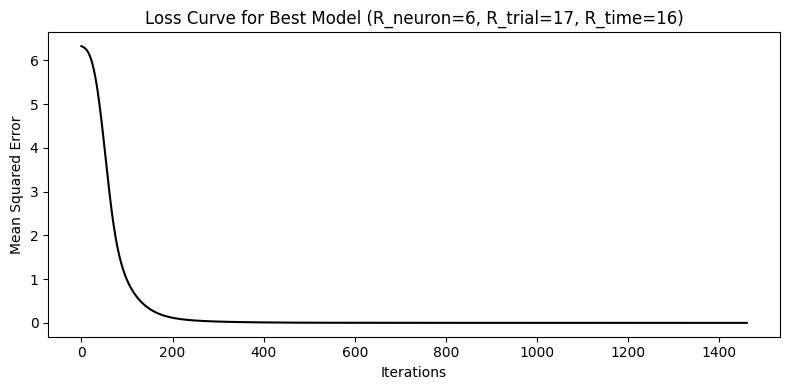


SliceTCA Decomposition: BLA Condition - Pre-stimulus (Best Model)


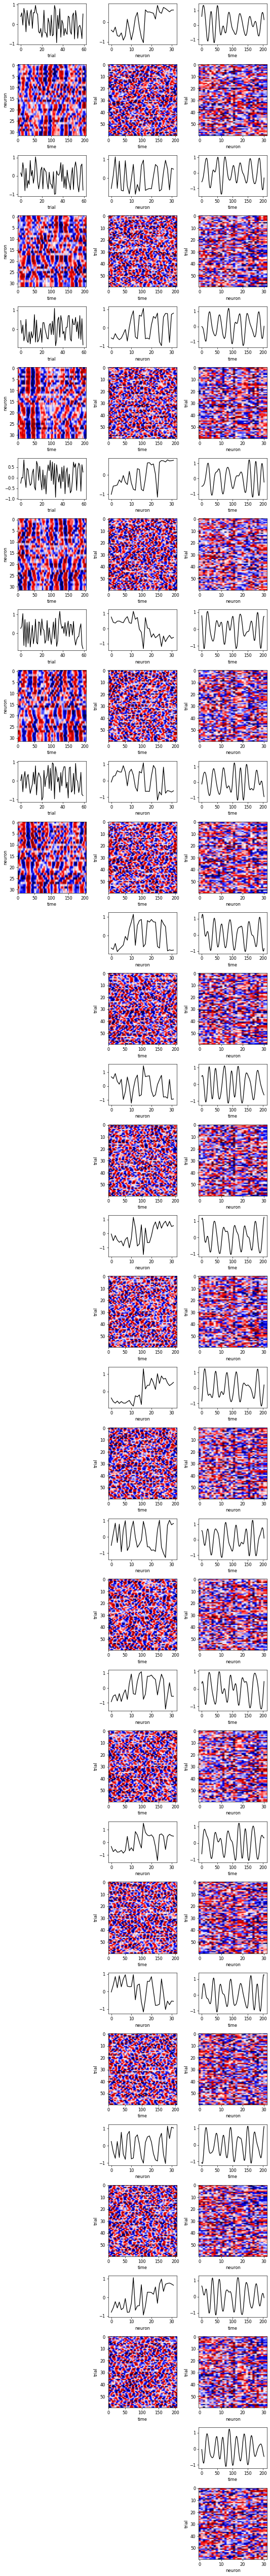

In [30]:
# Find the best parameters
if model_losses:
    best = min(model_losses, key=model_losses.get)
    print("\nResults:")
    print(f"Best model based on final loss: {best} with loss {model_losses[best]:.6f}")

    # Train final model with best parameters
    Rne, Rtr, Rti = best
    print(f"\nTraining final model with ranks: Neuron={Rne}, Trial={Rtr}, Time={Rti}")

    try:
        # Train the final model with more iterations
        components, final_model = slicetca.decompose(
            data,
            (Rne, Rti, Rtr),  # Note ordering (neuron, time, trial)
            max_iter=5000
        )

        # Plot loss curve
        if hasattr(final_model, 'losses'):
            plt.figure(figsize=(8, 4))
            plt.plot(np.arange(len(final_model.losses)), final_model.losses, 'k')
            plt.xlabel('Iterations')
            plt.ylabel('Mean Squared Error')
            plt.title(f'Loss Curve for Best Model (R_neuron={Rne}, R_trial={Rtr}, R_time={Rti})')
            plt.tight_layout()
            plt.show()

        # Try to plot using slicetca.plot
        try:
            print("\nSliceTCA Decomposition: BLA Condition - Pre-stimulus (Best Model)")
            slicetca.plot(final_model)
            plt.show()
        except Exception as e:
            print(f"Could not use slicetca.plot: {e}")

            # Manual plotting as fallback
            if hasattr(final_model, 'vectors'):
                vectors = final_model.vectors
                if len(vectors) == 3:
                    U, V, W = vectors

                    plt.figure(figsize=(15, 10))

                    # Plot neuron factors
                    plt.subplot(3, 1, 1)
                    for r in range(min(5, U.shape[1])):
                        plt.plot(np.arange(U.shape[0]), U[:, r].cpu().numpy(), label=f'Comp {r+1}')
                    plt.title('Neuron Factors')
                    plt.legend()

                    # Plot time factors
                    plt.subplot(3, 1, 2)
                    for r in range(min(5, V.shape[1])):
                        plt.plot(np.arange(V.shape[0]), V[:, r].cpu().numpy(), label=f'Comp {r+1}')
                    plt.title('Time Factors')
                    plt.legend()

                    # Plot trial factors
                    plt.subplot(3, 1, 3)
                    for r in range(min(5, W.shape[1])):
                        plt.plot(np.arange(W.shape[0]), W[:, r].cpu().numpy(), label=f'Comp {r+1}')
                    plt.title('Trial Factors')
                    plt.legend()

                    plt.tight_layout()
                    plt.show()

    except Exception as e:
        print(f"Error with final model: {e}")
else:
    print("No valid results were obtained. Try different parameters.")




Processing post-stimulus data with the same best parameters
Post-stimulus data shape: torch.Size([60, 32, 205])


The model converged. Loss: 0.0004622816923074424 :  30%|███       | 1523/5000 [00:26<01:01, 56.47it/s]


SliceTCA Decomposition: BLA Condition - Post-stimulus


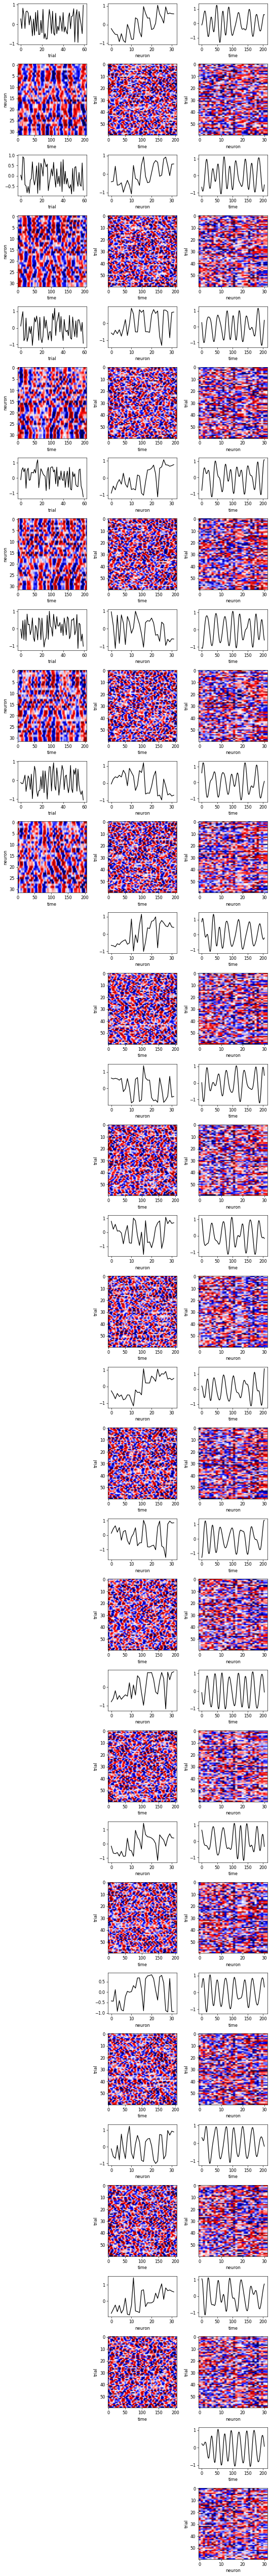

In [31]:
print("\n\nProcessing post-stimulus data with the same best parameters")
try:
    X_post = mat['post_data'].astype(np.float32)
    X_post = np.transpose(X_post, (2, 0, 1))
    data_post = torch.tensor(X_post, dtype=torch.float, device=device)
    print(f"Post-stimulus data shape: {data_post.shape}")

    # Use the same best parameters
    components_post, model_post = slicetca.decompose(
        data_post,
        (Rne, Rti, Rtr),
        max_iter=5000
    )

    print("SliceTCA Decomposition: BLA Condition - Post-stimulus")
    try:
        slicetca.plot(model_post)
        plt.show()
    except Exception as e:
        print(f"Could not use slicetca.plot for post-stimulus: {e}")

        # Manual plotting
        if hasattr(model_post, 'vectors'):
            vectors = model_post.vectors
            if len(vectors) == 3:
                U, V, W = vectors

                plt.figure(figsize=(15, 10))

                # Plot neuron factors
                plt.subplot(3, 1, 1)
                for r in range(min(5, U.shape[1])):
                    plt.plot(np.arange(U.shape[0]), U[:, r].cpu().numpy(), label=f'Comp {r+1}')
                plt.title('Post-stimulus Neuron Factors')
                plt.legend()

                # Plot time factors
                plt.subplot(3, 1, 2)
                for r in range(min(5, V.shape[1])):
                    plt.plot(np.arange(V.shape[0]), V[:, r].cpu().numpy(), label=f'Comp {r+1}')
                plt.title('Post-stimulus Time Factors')
                plt.legend()

                # Plot trial factors
                plt.subplot(3, 1, 3)
                for r in range(min(5, W.shape[1])):
                    plt.plot(np.arange(W.shape[0]), W[:, r].cpu().numpy(), label=f'Comp {r+1}')
                plt.title('Post-stimulus Trial Factors')
                plt.legend()

                plt.tight_layout()
                plt.show()

except Exception as e:
    print(f"Error processing post-stimulus data: {e}")

# 3. Run Model with optimized factor numbers

In [37]:
# ————————————————
# Hyperparameters
# ————————————————
R_neuron = 6    # e.g. start with 2 neuron‐slicing comps
R_trial  = 17    # e.g. 4 trial‐slicing comps
R_time   = 16    # e.g. 1 time‐slicing comp

In [38]:
# ————————————————
# Initialize and fit model
# ————————————————

components, final_model = slicetca.decompose(data,
                    (R_neuron,R_time,R_trial),
                    max_iter=5000)

The model converged. Loss: 0.0003959576424676925 :  29%|██▉       | 1460/5000 [00:26<01:04, 54.96it/s]


In [39]:
# For a not positive decomposition, we apply uniqueness constraints
model = slicetca.invariance(final_model)

The invariance converged. Invariance loss: 2.9725632667541504 :  21%|██        | 2054/10000 [00:35<02:16, 58.16it/s]


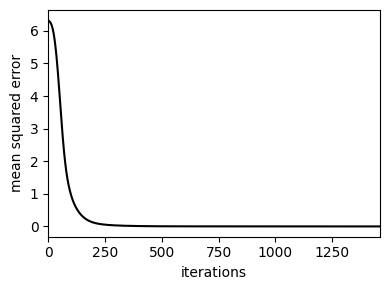

In [42]:
plt.figure(figsize=(4,3), dpi=100)
plt.plot(np.arange(00,len(final_model.losses)), final_model.losses, 'k')
plt.xlabel('iterations')
plt.ylabel('mean squared error')
plt.xlim(0,len(model.losses))
plt.tight_layout()

In [43]:
final_model

SliceTCA(
  (vectors): ModuleList(
    (0): ParameterList(
        (0): Parameter containing: [torch.float32 of size 6x60 (cuda:0)]
        (1): Parameter containing: [torch.float32 of size 6x32x204 (cuda:0)]
    )
    (1): ParameterList(
        (0): Parameter containing: [torch.float32 of size 16x32 (cuda:0)]
        (1): Parameter containing: [torch.float32 of size 16x60x204 (cuda:0)]
    )
    (2): ParameterList(
        (0): Parameter containing: [torch.float32 of size 17x204 (cuda:0)]
        (1): Parameter containing: [torch.float32 of size 17x60x32 (cuda:0)]
    )
  )
)

In [ ]:
print("SliceTCA Decomposition: BLA Condition - Pre-stimulus")
slicetca.plot(model_post)
# plt.suptitle( fontsize=14)
plt.show()

In [ ]:
print("SliceTCA Decomposition: BLA Condition - Pre-stimulus")
slicetca.plot(model)
# plt.suptitle( fontsize=14)
plt.show()

In [ ]:
components_post, final_model_post = slicetca.decompose(data_post,
                    (R_neuron,R_time,R_trial),
                    max_iter=5000)

In [ ]:
# For a not positive decomposition, we apply uniqueness constraints
model_post = slicetca.invariance(final_model_post)

In [ ]:
print("SliceTCA Decomposition: BLA Condition - post-stimulus")
slicetca.plot(model_post)
plt.show()

In [ ]:
plt.figure(figsize=(4,3), dpi=100)
plt.plot(np.arange(1000,len(model_post.losses)), model_post.losses[1000:], 'k')
plt.xlabel('iterations')
plt.ylabel('mean squared error')
plt.xlim(0,len(model_post.losses))
plt.tight_layout()